In [15]:
# Import Packages

import os
import csv
import scvi
import rdata
import igraph
import pprint
import leidenalg
import muon as mu
import liana as li
import numpy as np
import pandas as pd
import scanpy as sc
import mudata as md
import anndata as ad
import pyranges as pr
import seaborn as sns
import scrublet as scr
import harmonypy as hm
from scipy import stats
from scipy.io import mmread
import matplotlib.pyplot as plt
from itertools import combinations
from adjustText import adjust_text
from scipy.sparse import csr_matrix
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

mu.set_options(pull_on_update=False)

In [ ]:
# read data

data_path = '/folder1/filtered_feature_bc_matrix/'
mdata = mu.read_10x_mtx(data_path)

In [4]:
# qc (quality control)
mdata['rna'] = mdata['rna'][(mdata['rna'].obs['n_genes_by_counts'] < 20000) & (mdata['rna'].obs['n_genes_by_counts'] > 300), :]
mdata['atac'] = mdata['atac'][(mdata['atac'].obs['n_genes_by_counts'] < 100000) & (mdata['atac'].obs['n_genes_by_counts'] > 1000), :]

# pct_mt qc
mdata['rna'].var['mt'] = mdata['rna'].var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(mdata['rna'], qc_vars=['mt'], inplace=True)
mdata['rna'] = mdata['rna'][mdata['rna'].obs.pct_counts_mt < 30]

# ribosomal gene qc
ribosomal_genes = mdata['rna'].var_names.str.startswith('RPS') | mdata['rna'].var_names.str.startswith('RPL')
mdata['rna'].obs['percent_ribosomal'] = mdata['rna'][:, ribosomal_genes].X.sum(axis=1) / mdata['rna'].X.sum(axis=1) * 100
mdata['rna'] = mdata['rna'][(mdata['rna'].obs['percent_ribosomal'] < 60) & (mdata['rna'].obs['percent_ribosomal'] > 10), :]

# nucleosome qc
mdata['atac'].uns['files'] = {'fragments': '/folder2/atac_fragments.tsv.gz'}
mu.atac.pp.nucleosome_signal(mdata['atac'], n=1e5)
mu.pp.filter_obs(mdata['atac'], 'nucleosome_signal', lambda x: 1 < x < 2)

# doublet removal
counts_matrix = mdata['rna'].X
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.05)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
mdata['rna'].obs['doublet_score'] = doublet_scores
mdata['rna'].obs['predicted_doublet'] = predicted_doublets
mdata['rna'] = mdata['rna'][~predicted_doublets]

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 22.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.5%
Elapsed time: 0.7 seconds


In [ ]:
# GEX data PCA calculation and Harmony

sc.pp.normalize_total(mdata['rna'], target_sum=1e4)
sc.pp.log1p(mdata['rna'])
sc.pp.highly_variable_genes(mdata['rna'], n_top_genes=2000, batch_key=None)
sc.tl.pca(mdata['rna'], svd_solver='arpack')
sce.pp.harmony_integrate(
    mdata['rna'], 
    key=batch_key, 
    basis='X_pca', 
    adjusted_basis='X_harmony'
)

In [ ]:
# ATAC data LSI calculation and Harmony

sc.pp.filter_genes(mdata['atac'], min_cells=1)
mu.atac.pp.tfidf(mdata['atac'], scale_factor=1e4)
sc.pp.highly_variable_genes(mdata['atac'], n_top_genes=10000, batch_key=None)
mu.atac.tl.lsi(mdata['atac'])
sce.pp.harmony_integrate(
    mdata['atac'], 
    key=batch_key, 
    basis='X_lsi',
    adjusted_basis='X_harmony'
)

Processing RNA...
Processing ATAC...
Running WNN...


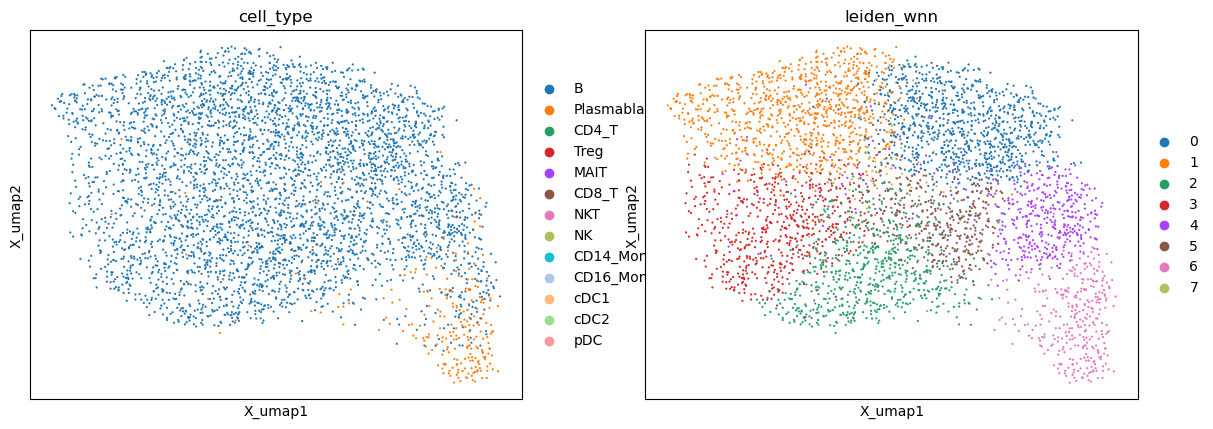

In [6]:
# WNN

sc.pp.neighbors(mdata['rna'], use_rep='X_harmony', n_neighbors=10, n_pcs=15)
sc.pp.neighbors(mdata['atac'], use_rep="X_harmony", n_neighbors=10, n_pcs=20)

mu.pp.neighbors(mdata, key_added='wnn')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.tl.umap(mdata, neighbors_key='wnn')
mu.pl.umap(mdata, color=['leiden_wnn'], neighbors_key='wnn')

In [ ]:
# Making Subsets

In [12]:
B_mdata = mdata[mdata.obs['cell_type_abstract'] == 'B Cell']
B_mdata.write('/data/imindol02/COVID_multiome/COVID_Objects/B_mdata_COVID.h5mu')

In [12]:
T_mdata = mdata[mdata.obs['cell_type_abstract'] == 'T Cell']
T_mdata.write('/data/imindol02/COVID_multiome/COVID_Objects/T_mdata_COVID.h5mu')

In [12]:
NK_mdata = mdata[mdata.obs['cell_type_abstract'] == 'NK/NKT Cell']
NK_mdata.write('/data/imindol02/COVID_multiome/COVID_Objects/NK_mdata_COVID.h5mu')

In [12]:
M_mdata = mdata[mdata.obs['cell_type_abstract'] == 'Myeloid Cell']
M_mdata.write('/data/imindol02/COVID_multiome/COVID_Objects/M_mdata_COVID.h5mu')

In [ ]:
# Codes for Drawing Figures from now on

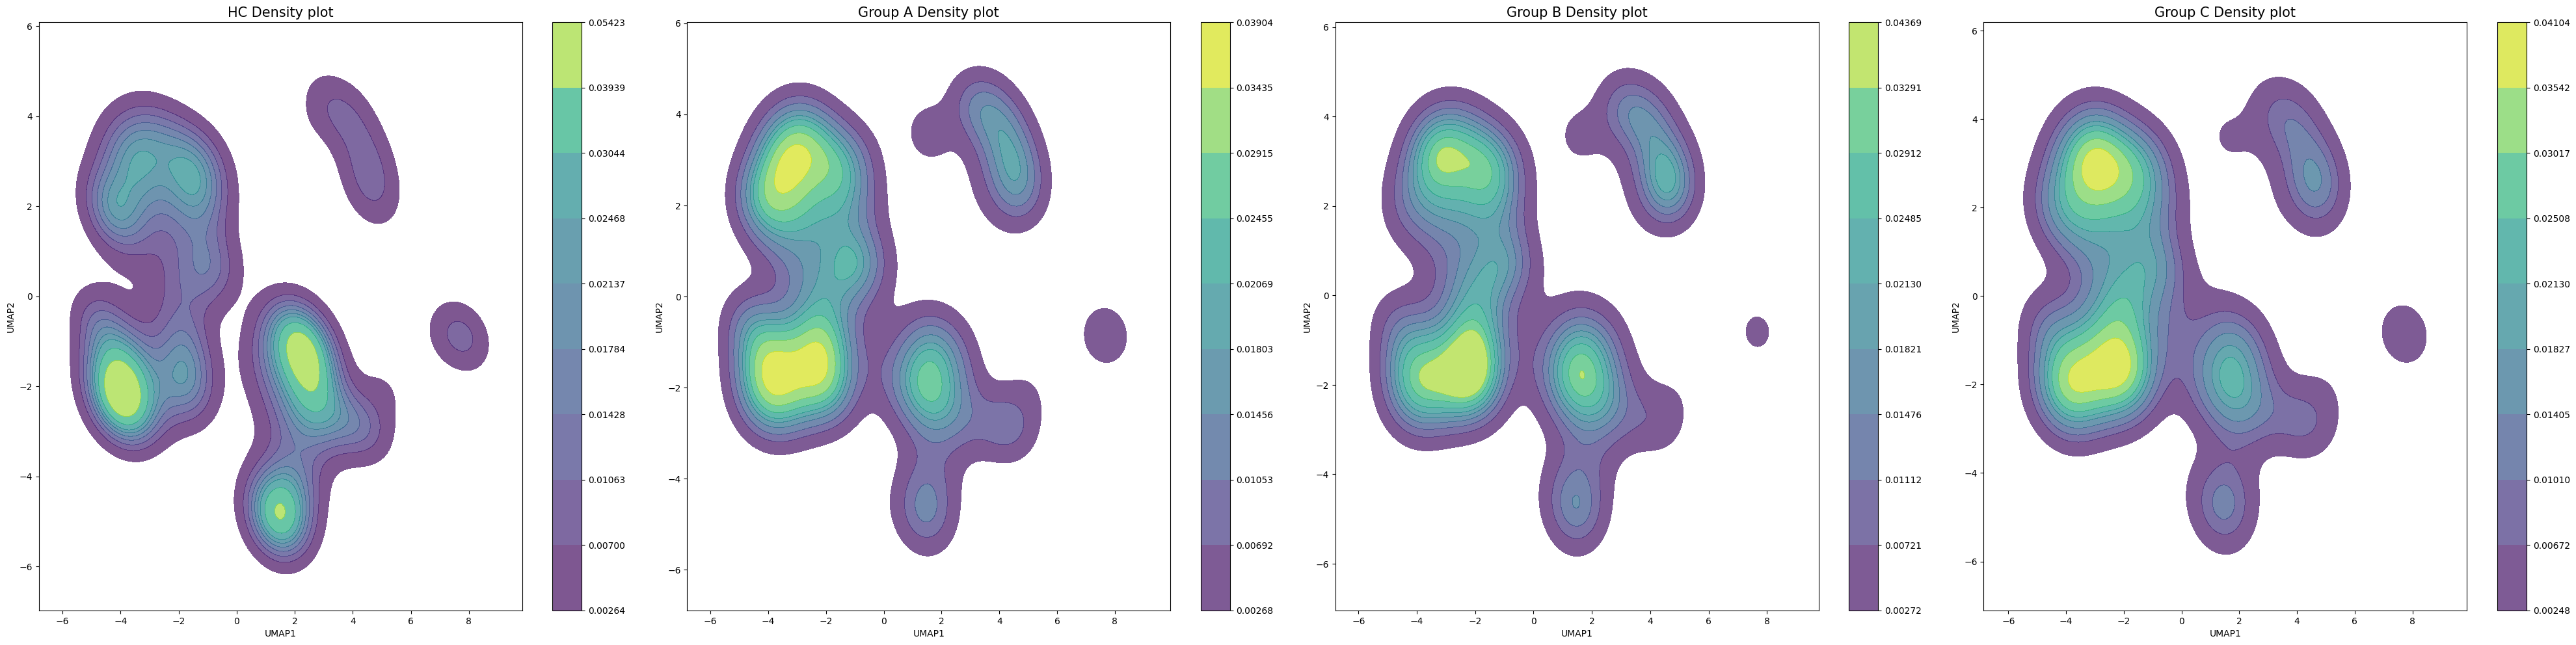

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))
treatment_list = list(mdata.obs['vaccine type'].cat.categories)

for i, Tx in enumerate(treatment_list):
    ax = axes[i]
    plot_df = mdata_Tx[Tx].obs.copy()
    plot_df['UMAP1'] = mdata_Tx[Tx].obsm['X_umap'][:, 0]
    plot_df['UMAP2'] = mdata_Tx[Tx].obsm['X_umap'][:, 1]
    sns.kdeplot(
        x=plot_df['UMAP1'], 
        y=plot_df['UMAP2'], 
        ax=ax,
        cmap="viridis",         
        fill=True,
        alpha=0.7,
        cbar=True,
    )
    ax.set_title(f'{Tx} Density plot', fontsize=15)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    
fig.tight_layout(pad=1)
plt.show()

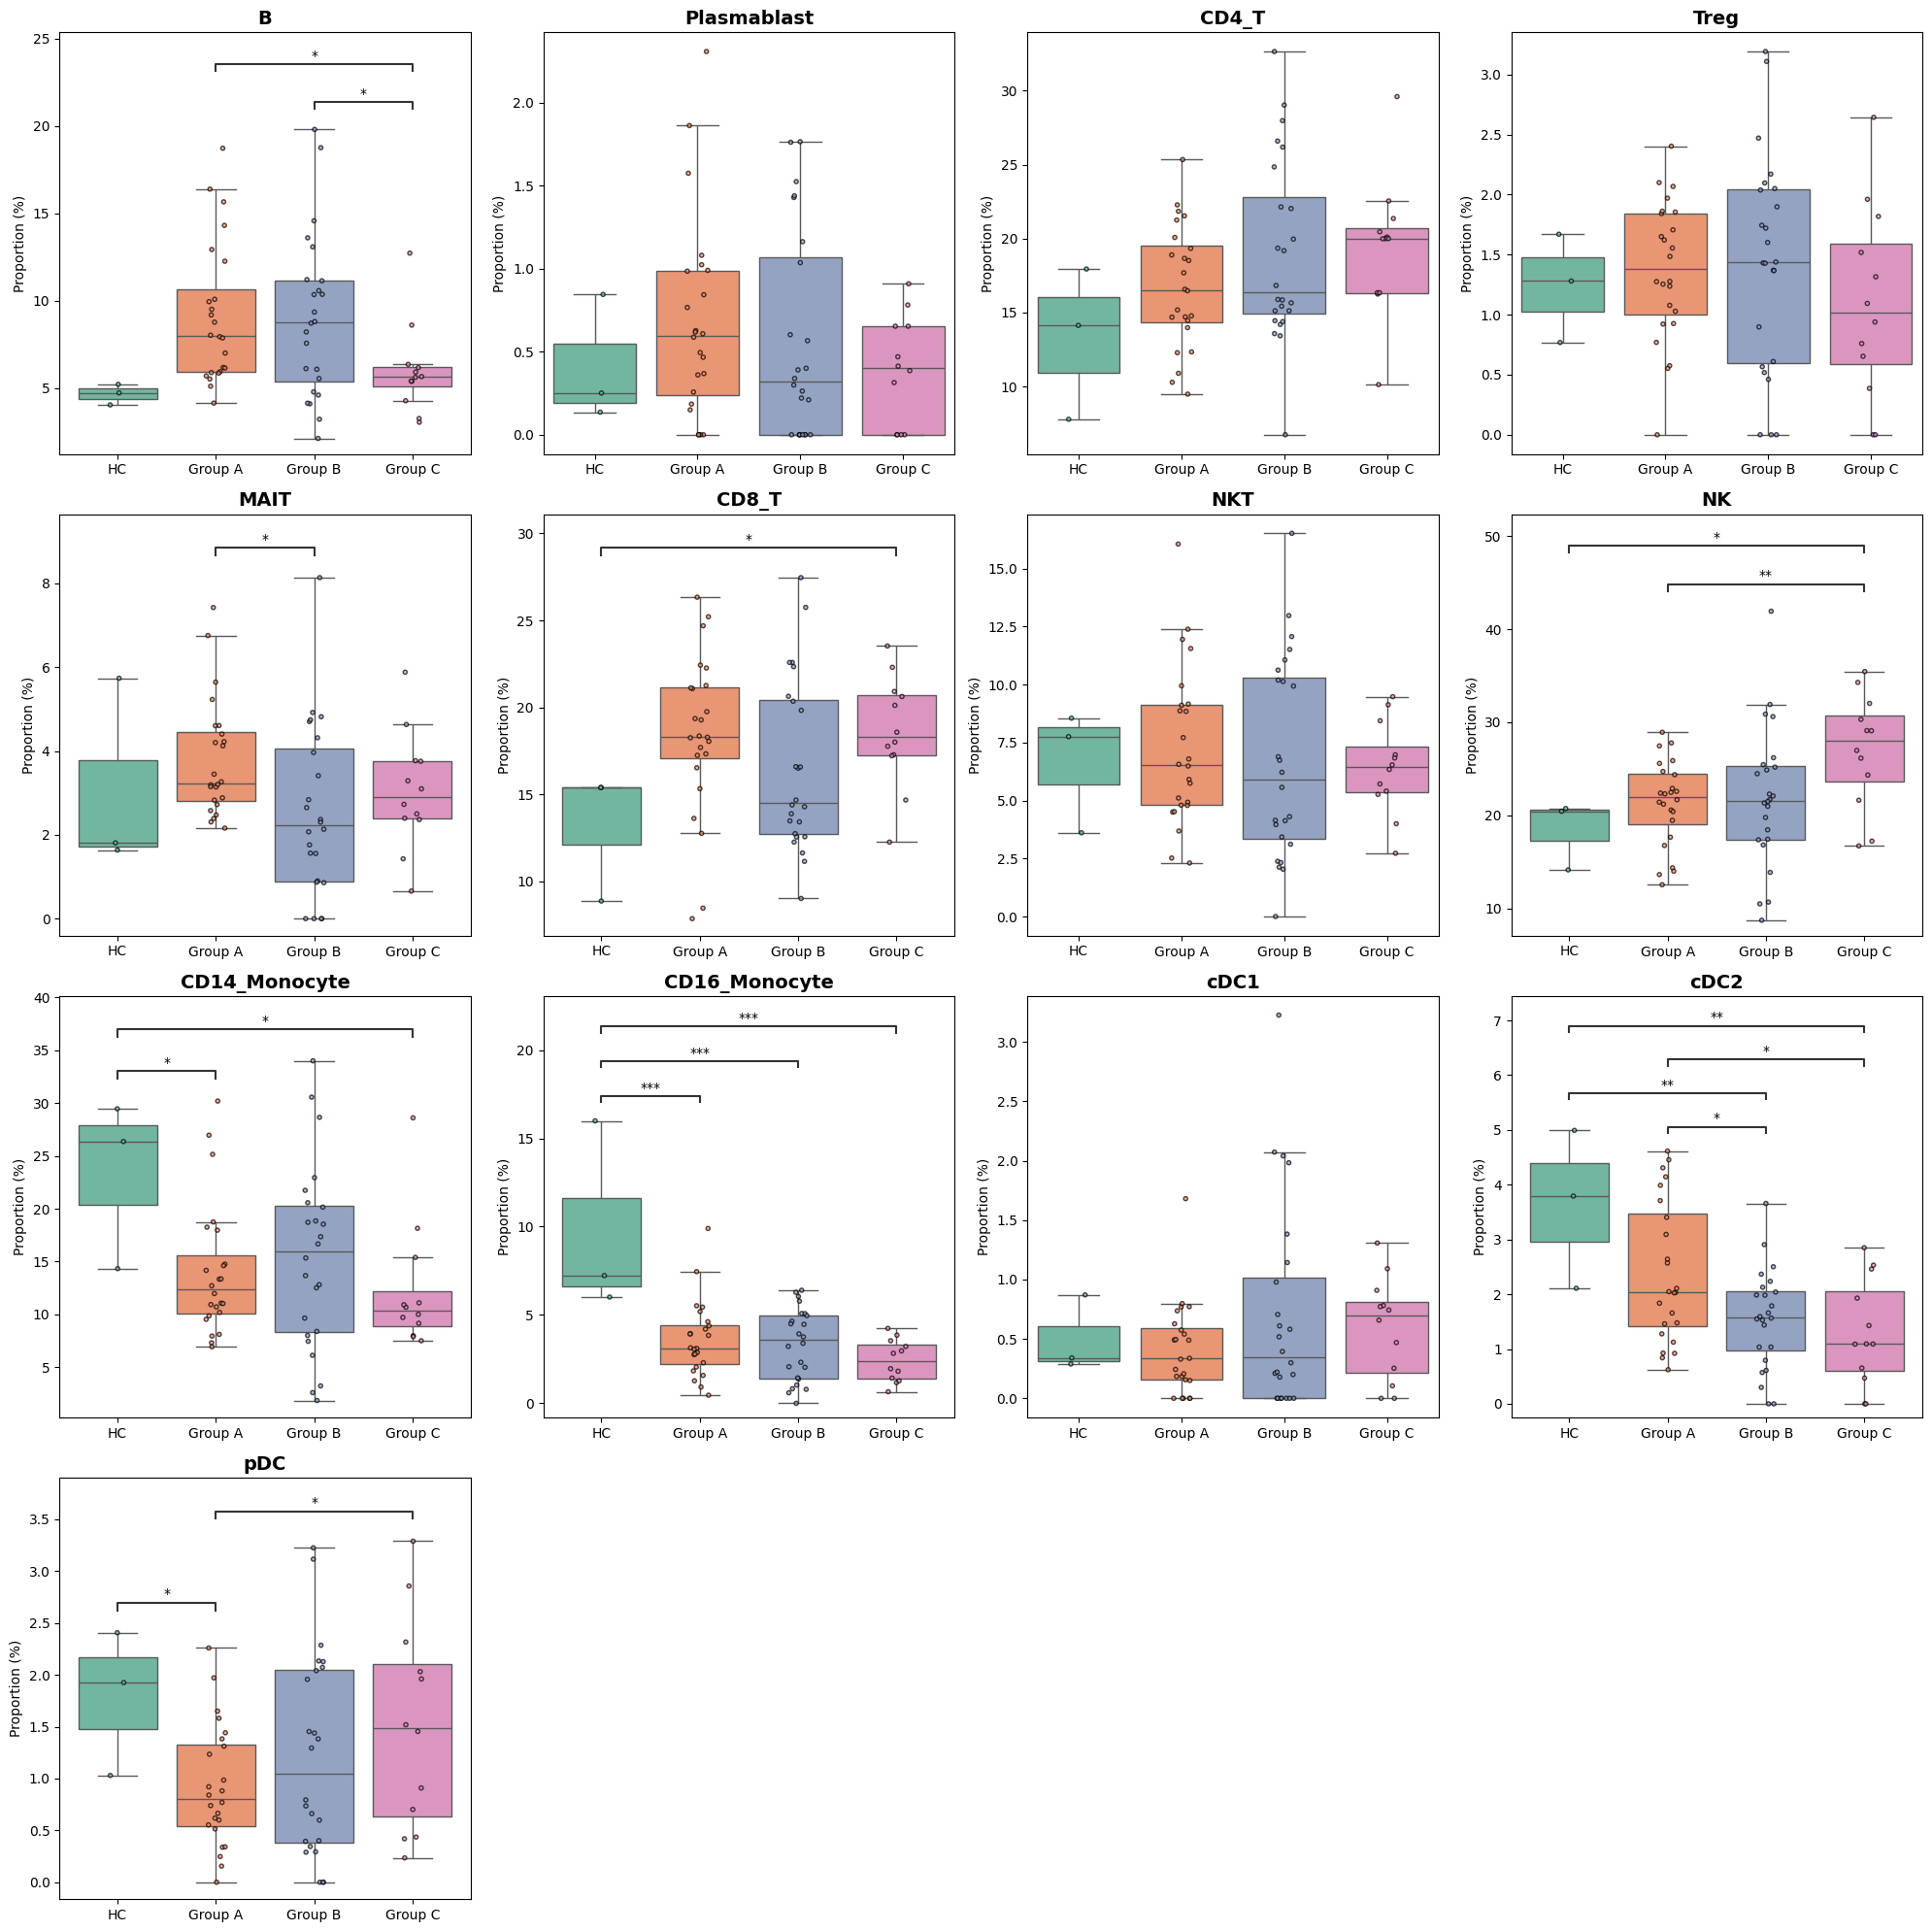

In [27]:
cell_types = props.columns.drop('vaccine type')
n_cols = 4
n_rows = (len(cell_types) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()
order = ['HC', 'Group A', 'Group B', 'Group C']
pairs = list(combinations(order, 2))

for i, c_type in enumerate(cell_types):
    ax = axes[i]
    sns.boxplot(
        data=props, 
        x='vaccine type', 
        y=c_type,
        order=order,
        hue='vaccine type',
        ax=ax, 
        palette="Set2", 
        showfliers=False
    )
    sns.stripplot(
        data=props, 
        x='vaccine type', 
        y=c_type, 
        ax=ax,
        hue='vaccine type',
        palette="Set2",
        edgecolor='black',
        linewidth=1,
        size=3,
        alpha=0.7,
        jitter=True
    )
    annotator = Annotator(ax, pairs, data=props, x='vaccine type', y=c_type, order=order)
    annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0, hide_non_significant=True)
    annotator.apply_and_annotate()
    ax.set_title(c_type, fontsize=14, fontweight='bold')
    ax.set_ylabel("Proportion (%)")
    ax.set_xlabel("")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [20]:
genes_of_interest = [
    # B cell
    "BLK", "MS4A1", "CD79A", "CD79B", "TNFRSF13C",
    # Plasmablast
    "MZB1", "SDC1", "JCHAIN",
    # T cell
    "CD3D", "CD3E", "CD3G", "TRAC", "TRBC1", "TRBC2",
    # CD4 T cell
    "CD4", "IL7R",
    # Treg
    "FOXP3", "IL2RA", "CTLA4",
    # MAIT
    "SLC4A10", "KLRB1",
    # CD8 T cell
    "CD8A", "CD8B",
    # Killer cell
    "CST7", "GZMA",
    # NK cell
    "NKG7", "KLRK1", "KLRF1", "GNLY", "NCAM1",
    # Monocyte
    "CD68", "MSR1", "IFI30",
    # CD14 Monocyte
    "CD14", "S100A8", "S100A9",
    # CD16 Monocyte
    "FCGR3A", "MS4A7",
    # DC
    "ITGAX", "HLA-DRA", "HLA-DRB1", "HLA-DQA1",
    # cDC1
    "CLEC9A", "XCR1",
    # cDC2
    "CD1C", "FCER1A",
    # pDC
    "IL3RA", "CLEC4C", "LILRA4"
]

/home/imindol02/anaconda3/envs/kms/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:2058: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.


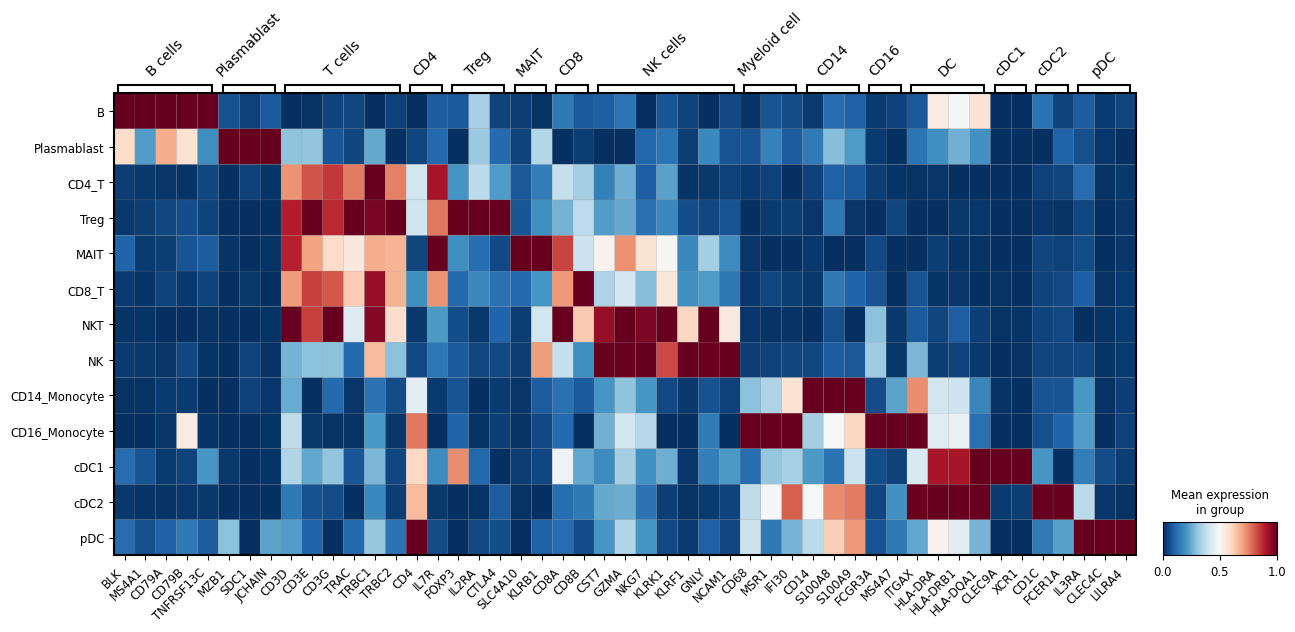

In [21]:
ax_dict = sc.pl.matrixplot(
    mdata['rna'],
    var_names=genes_of_interest,
    groupby='celltype',
    use_raw=False,
    swap_axes=False,
    standard_scale='var',
    cmap='RdBu_r',
    figsize=(15,6),
    var_group_positions = [(0,4), (5,7),
                           (8,13), (14,15), (16,18), (19,20), (21,22), (23,29),
                           (30,32), (33,35), (36,37), (38,41), (42,43), (44,45), (46,48)],
    var_group_labels = ['B cells', 'Plasmablast',
                        'T cells', 'CD4', 'Treg', 'MAIT', 'CD8', 'NK cells',
                        'Myeloid cell', 'CD14', 'CD16', 'DC', 'cDC1', 'cDC2', 'pDC'],
    var_group_rotation = 45
)
ax = ax_dict['mainplot_ax']
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()